In [1]:
import rioxarray as rxr
import numpy as np
import joblib
import os
from tqdm import tqdm
import json

In [2]:
# Load model đã train
model_path = r'../OUTPUT/train_model/random_forest_model.pkl'
rf_model = joblib.load(model_path)


In [3]:
# Load dữ liệu raster toàn bộ
raster_path = r'../INPUT/stacked/final_stack.tif'
raster_data = rxr.open_rasterio(raster_path)

print(f"Shape của raster: {raster_data.shape}")
print(f"CRS: {raster_data.rio.crs}")
print(f"Bounds: {raster_data.rio.bounds()}")
print(f"Số lượng bands: {raster_data.shape[0]}")
print(f"Kích thước ảnh: {raster_data.shape[1]} x {raster_data.shape[2]}")

Shape của raster: (25, 510, 520)
CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Bounds: (108.08242037635165, 13.067433111973031, 108.12913277112587, 13.113247191463127)
Số lượng bands: 25
Kích thước ảnh: 510 x 520


In [4]:
# Chuẩn bị dữ liệu cho prediction
# Reshape từ (bands, height, width) sang (height*width, bands)
n_bands, height, width = raster_data.shape

# Chuyển đổi sang numpy array và reshape
raster_array = raster_data.values
X_predict = raster_array.reshape(n_bands, -1).T  # Shape: (height*width, bands)

print(f"Shape của X_predict: {X_predict.shape}")
print(f"Tổng số pixel cần dự đoán: {X_predict.shape[0]:,}")
print(f"Số lượng features: {X_predict.shape[1]}")

Shape của X_predict: (265200, 25)
Tổng số pixel cần dự đoán: 265,200
Số lượng features: 25


In [5]:
# Xử lý NaN và Inf
print("Kiểm tra giá trị NaN và Inf...")
nan_mask = np.isnan(X_predict).any(axis=1)
inf_mask = np.isinf(X_predict).any(axis=1)
invalid_mask = nan_mask | inf_mask

print(f"Số pixel có NaN: {nan_mask.sum():,}")
print(f"Số pixel có Inf: {inf_mask.sum():,}")
print(f"Tổng số pixel không hợp lệ: {invalid_mask.sum():,}")

# Tạo mảng kết quả, gán -1 cho pixel không hợp lệ
predictions = np.full(X_predict.shape[0], -1, dtype=np.int16)

# Chỉ predict cho các pixel hợp lệ
valid_indices = ~invalid_mask
X_valid = X_predict[valid_indices]

print(f"\nSố pixel hợp lệ để dự đoán: {X_valid.shape[0]:,}")

Kiểm tra giá trị NaN và Inf...
Số pixel có NaN: 10,622
Số pixel có Inf: 0
Tổng số pixel không hợp lệ: 10,622

Số pixel hợp lệ để dự đoán: 254,578


In [6]:
# Dự đoán cho toàn bộ ảnh
print("Đang dự đoán...")

# Dự đoán theo batch để tránh tràn bộ nhớ
batch_size = 100000  # Điều chỉnh nếu cần
n_valid = X_valid.shape[0]
n_batches = (n_valid + batch_size - 1) // batch_size

y_pred_valid = []
for i in tqdm(range(n_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, n_valid)
    batch = X_valid[start_idx:end_idx]
    batch_pred = rf_model.predict(batch)
    y_pred_valid.append(batch_pred)

# Kết hợp kết quả
y_pred_valid = np.concatenate(y_pred_valid)

# Gán kết quả vào mảng predictions
predictions[valid_indices] = y_pred_valid

print(f"\n✅ Dự đoán hoàn tất!")
print(f"Số pixel được dự đoán: {(predictions >= 0).sum():,}")
print(f"Số pixel class 0 (Khác): {(predictions == 0).sum():,}")
print(f"Số pixel class 1 (Cao su): {(predictions == 1).sum():,}")
print(f"Số pixel không hợp lệ: {(predictions == -1).sum():,}")

Đang dự đoán...


  0%|                                                                                                                   | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███████████████████████████████████▋                                                                       | 1/3 [00:00<00:00,  8.58it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|██████████████████████████████████████████████████████████████████


✅ Dự đoán hoàn tất!
Số pixel được dự đoán: 254,578
Số pixel class 0 (Khác): 181,409
Số pixel class 1 (Cao su): 73,169
Số pixel không hợp lệ: 10,622


In [7]:
# Reshape kết quả về dạng 2D (height, width)
prediction_map = predictions.reshape(height, width)

# Tạo xarray DataArray với thông tin địa lý
prediction_raster = rxr.open_rasterio(raster_path, masked=True)
prediction_da = prediction_raster[0].copy()  # Lấy 1 band làm template
prediction_da.values = prediction_map

# Lưu kết quả
output_dir = '../OUTPUT/prediction'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'prediction_cao_su.tif')

prediction_da.rio.to_raster(output_path, dtype='int16')

print(f"\n🎉 Đã lưu kết quả dự đoán tại: {output_path}")
print(f"\nGiá trị trong file:")
print(f"  -1: Pixel không hợp lệ (NaN/Inf)")
print(f"   0: Khác")
print(f"   1: Cao su")


🎉 Đã lưu kết quả dự đoán tại: ../OUTPUT/prediction\prediction_cao_su.tif

Giá trị trong file:
  -1: Pixel không hợp lệ (NaN/Inf)
   0: Khác
   1: Cao su


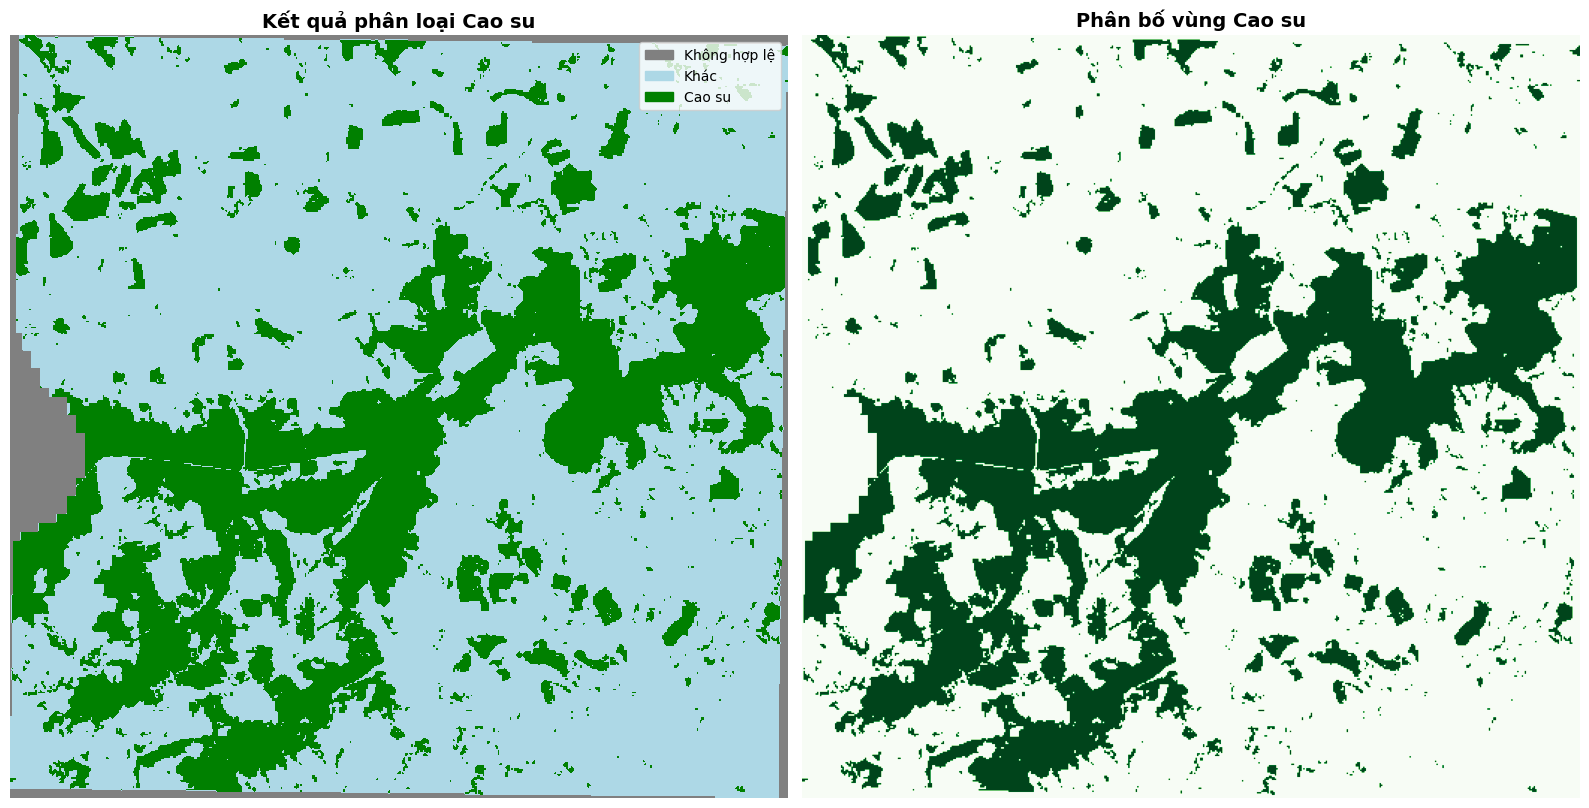


📊 Đã lưu visualization tại: ../OUTPUT/prediction\visualization.png


In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Visualize kết quả dự đoán
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Kết quả phân loại với 3 class (-1, 0, 1)
colors = ['gray', 'lightblue', 'green']  # gray: invalid, lightblue: khác, green: cao su
cmap = ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5]

im1 = axes[0].imshow(prediction_map, cmap=cmap, vmin=-1, vmax=1)
axes[0].set_title('Kết quả phân loại Cao su', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Tạo legend
patches = [
    mpatches.Patch(color='gray', label='Không hợp lệ'),
    mpatches.Patch(color='lightblue', label='Khác'),
    mpatches.Patch(color='green', label='Cao su')
]
axes[0].legend(handles=patches, loc='upper right', fontsize=10)

# Plot 2: Chỉ hiển thị cao su (class 1)
rubber_only = prediction_map.copy()
rubber_only[rubber_only != 1] = 0  # Chỉ giữ lại class 1

im2 = axes[1].imshow(rubber_only, cmap='Greens', vmin=0, vmax=1)
axes[1].set_title('Phân bố vùng Cao su', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'visualization.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Đã lưu visualization tại: {os.path.join(output_dir, 'visualization.png')}")